In [2]:
# load modules
#--------------------------------------------------------------
import numpy as np
import pandas as pd
import sys, os, time
import datetime
import re
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt
import ray
sys.path.append('../..')

# import helpers
from src.utils import interp, get_xs, Params, get_xtv
from src.plots import scatter_plot, line_plot


from src.models.chain_gaussian import Chain_Gaussian
from src.mcmc_diagnostics.diagnostic import MCMCDiagnostic
from src.utils.serialize import pickle_obj, unpickle_obj, load_json, save_json

# import sampler classes
from src.sampling_algorithms import MaskedLocalBPS, LocalBPS
from src.sampling_algorithms.masked_bps.dynamic_masked_bps import DynamicMaskedLocalBPS
from src.sampling_algorithms.masked_bps.dynamic_reader import OutputReader,output_chain_fp_constructor, states_fp_constructor
from src.plots.arrow_plot import arrow_plot
# plot settings
from matplotlib import rc
rc('text', usetex=True)

import arviz as az
from arviz.stats import ess
az.style.use('arviz-darkgrid')

In [3]:
params1 = Params({
    "refresh_rate": 0.1,
    "overlap": 1,
    "num_factors": 10,
    "factor_dim": 3,
    "mu": 0.,
    "prec":1.,
    "rho": 0.,
    'run_time': 30,
    'num_workers': 5
})

In [4]:
params2 = Params({
    "refresh_rate": 0.1,
    "overlap": 0,
    "num_factors": 1,
    "factor_dim": 21,
    "mu": 0.,
    "prec":1.,
    "rho": 0.,
    'run_time': 30,
    'num_workers': 5
})
output_dir = "./output"

In [5]:
## Define model
model1 = Chain_Gaussian(params1)
model2 = Chain_Gaussian(params2)
model1.dim_x, model2.dim_x

(21, 21)

In [9]:
## Define model
model1 = Chain_Gaussian(params1)
model2 = Chain_Gaussian(params2)
factor_graphs = [model1, model2]

parent_dir = '../..'
os.environ["PYTHONPATH"] = parent_dir + ":" + os.environ.get("PYTHONPATH", "")

# Shutdown and init ray
if ray.is_initialized():
    ray.shutdown()

ray.init(memory=10**9, object_store_memory = 10**9)




# custom mask for demo, may result in errors if params edited and whole factor is masked!
def sample_graph_and_mask_fn():
    if np.random.random() < 0.5:
        fg_index = 0
    else:
        fg_index = 1
        
    model =factor_graphs[fg_index]
    mask = np.repeat(1., model.chain_length)
    ind_to_mask = np.random.choice(model.chain_length,1)
    mask[ind_to_mask] = 0.
    return fg_index, mask


fg_index, init_mask = sample_graph_and_mask_fn()



# init values
init_x = np.array([np.random.rand() for _ in range(model1.chain_length)])
init_v = np.array([np.random.rand() for _ in range(model1.chain_length)])

2020-03-09 16:46:11,631	WARNING worker.py:682 -- WARNING: Not updating worker name since `setproctitle` is not installed. Install this with `pip install setproctitle` (or ray[debug]) to enable monitoring of worker processes.
2020-03-09 16:46:11,634	WARNING services.py:592 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-03-09 16:46:11,636	INFO resource_spec.py:212 -- Starting Ray with 0.93 GiB memory available for workers and up to 0.93 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-03-09 16:46:11,922	WARNING services.py:1080 -- Failed to start the dashboard. The dashboard requires Python 3 as well as 'pip install aiohttp psutil setproctitle grpcio'.


In [10]:
# init sampler
#--------------------------------------------------------------------------------------
mlbps = DynamicMaskedLocalBPS(init_x = init_x,
                 init_v = init_v,
                 init_mask = init_mask,
                 init_fg = 0,
                 factor_graph_list = [model1, model2],
                 bounce_fn_list = [model1.bounce_fns, model2.bounce_fns],
                 refresh_rate = params1.refresh_rate,
                 split_mask_fn = model1.split_mask_into_groups,
                 sample_graph_and_mask_fn = sample_graph_and_mask_fn,
                 max_number_sub_samplers = params1.num_workers)

In [11]:
print('Masked Local BPS')
print(datetime.datetime.now())
res = mlbps.simulate_for_time(params1.run_time, output_dir)
results, groups, masks = res
print(datetime.datetime.now())

Masked Local BPS
2020-03-09 16:46:12.160541
2020-03-09 16:46:48.424910


In [12]:
output_reader = OutputReader(mlbps)

In [41]:
output_reader = OutputReader(mlbps)

output, num_iter = output_reader.read_output(output_dir, verbose = True, inplace=False)

chains = {}
for i in range(mlbps.d):
    x, v, t, mask = output[i]['x'], output[i]['v'], output[i]['t'], output[i]['mask']
    x = np.array(x)
    v = np.array(v)
    t = np.array(t)
    mask = np.array(mask)
    nsim = len(x)
    xs = interp(x, t, v*mask, num_intervals= len(x)*10)
    chains["$x_{0}$".format(i)] = xs

Check directory
Read output from directory: ./output
Check files
Number of parallel iterations: 4296
Read output files
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59
Iteration: 60
Iteration: 61
Iteration: 62
Iteration

Iteration: 570
Iteration: 571
Iteration: 572
Iteration: 573
Iteration: 574
Iteration: 575
Iteration: 576
Iteration: 577
Iteration: 578
Iteration: 579
Iteration: 580
Iteration: 581
Iteration: 582
Iteration: 583
Iteration: 584
Iteration: 585
Iteration: 586
Iteration: 587
Iteration: 588
Iteration: 589
Iteration: 590
Iteration: 591
Iteration: 592
Iteration: 593
Iteration: 594
Iteration: 595
Iteration: 596
Iteration: 597
Iteration: 598
Iteration: 599
Iteration: 600
Iteration: 601
Iteration: 602
Iteration: 603
Iteration: 604
Iteration: 605
Iteration: 606
Iteration: 607
Iteration: 608
Iteration: 609
Iteration: 610
Iteration: 611
Iteration: 612
Iteration: 613
Iteration: 614
Iteration: 615
Iteration: 616
Iteration: 617
Iteration: 618
Iteration: 619
Iteration: 620
Iteration: 621
Iteration: 622
Iteration: 623
Iteration: 624
Iteration: 625
Iteration: 626
Iteration: 627
Iteration: 628
Iteration: 629
Iteration: 630
Iteration: 631
Iteration: 632
Iteration: 633
Iteration: 634
Iteration: 635
Iteration:

Iteration: 1191
Iteration: 1192
Iteration: 1193
Iteration: 1194
Iteration: 1195
Iteration: 1196
Iteration: 1197
Iteration: 1198
Iteration: 1199
Iteration: 1200
Iteration: 1201
Iteration: 1202
Iteration: 1203
Iteration: 1204
Iteration: 1205
Iteration: 1206
Iteration: 1207
Iteration: 1208
Iteration: 1209
Iteration: 1210
Iteration: 1211
Iteration: 1212
Iteration: 1213
Iteration: 1214
Iteration: 1215
Iteration: 1216
Iteration: 1217
Iteration: 1218
Iteration: 1219
Iteration: 1220
Iteration: 1221
Iteration: 1222
Iteration: 1223
Iteration: 1224
Iteration: 1225
Iteration: 1226
Iteration: 1227
Iteration: 1228
Iteration: 1229
Iteration: 1230
Iteration: 1231
Iteration: 1232
Iteration: 1233
Iteration: 1234
Iteration: 1235
Iteration: 1236
Iteration: 1237
Iteration: 1238
Iteration: 1239
Iteration: 1240
Iteration: 1241
Iteration: 1242
Iteration: 1243
Iteration: 1244
Iteration: 1245
Iteration: 1246
Iteration: 1247
Iteration: 1248
Iteration: 1249
Iteration: 1250
Iteration: 1251
Iteration: 1252
Iteratio

Iteration: 1812
Iteration: 1813
Iteration: 1814
Iteration: 1815
Iteration: 1816
Iteration: 1817
Iteration: 1818
Iteration: 1819
Iteration: 1820
Iteration: 1821
Iteration: 1822
Iteration: 1823
Iteration: 1824
Iteration: 1825
Iteration: 1826
Iteration: 1827
Iteration: 1828
Iteration: 1829
Iteration: 1830
Iteration: 1831
Iteration: 1832
Iteration: 1833
Iteration: 1834
Iteration: 1835
Iteration: 1836
Iteration: 1837
Iteration: 1838
Iteration: 1839
Iteration: 1840
Iteration: 1841
Iteration: 1842
Iteration: 1843
Iteration: 1844
Iteration: 1845
Iteration: 1846
Iteration: 1847
Iteration: 1848
Iteration: 1849
Iteration: 1850
Iteration: 1851
Iteration: 1852
Iteration: 1853
Iteration: 1854
Iteration: 1855
Iteration: 1856
Iteration: 1857
Iteration: 1858
Iteration: 1859
Iteration: 1860
Iteration: 1861
Iteration: 1862
Iteration: 1863
Iteration: 1864
Iteration: 1865
Iteration: 1866
Iteration: 1867
Iteration: 1868
Iteration: 1869
Iteration: 1870
Iteration: 1871
Iteration: 1872
Iteration: 1873
Iteratio

Iteration: 2431
Iteration: 2432
Iteration: 2433
Iteration: 2434
Iteration: 2435
Iteration: 2436
Iteration: 2437
Iteration: 2438
Iteration: 2439
Iteration: 2440
Iteration: 2441
Iteration: 2442
Iteration: 2443
Iteration: 2444
Iteration: 2445
Iteration: 2446
Iteration: 2447
Iteration: 2448
Iteration: 2449
Iteration: 2450
Iteration: 2451
Iteration: 2452
Iteration: 2453
Iteration: 2454
Iteration: 2455
Iteration: 2456
Iteration: 2457
Iteration: 2458
Iteration: 2459
Iteration: 2460
Iteration: 2461
Iteration: 2462
Iteration: 2463
Iteration: 2464
Iteration: 2465
Iteration: 2466
Iteration: 2467
Iteration: 2468
Iteration: 2469
Iteration: 2470
Iteration: 2471
Iteration: 2472
Iteration: 2473
Iteration: 2474
Iteration: 2475
Iteration: 2476
Iteration: 2477
Iteration: 2478
Iteration: 2479
Iteration: 2480
Iteration: 2481
Iteration: 2482
Iteration: 2483
Iteration: 2484
Iteration: 2485
Iteration: 2486
Iteration: 2487
Iteration: 2488
Iteration: 2489
Iteration: 2490
Iteration: 2491
Iteration: 2492
Iteratio

Iteration: 3062
Iteration: 3063
Iteration: 3064
Iteration: 3065
Iteration: 3066
Iteration: 3067
Iteration: 3068
Iteration: 3069
Iteration: 3070
Iteration: 3071
Iteration: 3072
Iteration: 3073
Iteration: 3074
Iteration: 3075
Iteration: 3076
Iteration: 3077
Iteration: 3078
Iteration: 3079
Iteration: 3080
Iteration: 3081
Iteration: 3082
Iteration: 3083
Iteration: 3084
Iteration: 3085
Iteration: 3086
Iteration: 3087
Iteration: 3088
Iteration: 3089
Iteration: 3090
Iteration: 3091
Iteration: 3092
Iteration: 3093
Iteration: 3094
Iteration: 3095
Iteration: 3096
Iteration: 3097
Iteration: 3098
Iteration: 3099
Iteration: 3100
Iteration: 3101
Iteration: 3102
Iteration: 3103
Iteration: 3104
Iteration: 3105
Iteration: 3106
Iteration: 3107
Iteration: 3108
Iteration: 3109
Iteration: 3110
Iteration: 3111
Iteration: 3112
Iteration: 3113
Iteration: 3114
Iteration: 3115
Iteration: 3116
Iteration: 3117
Iteration: 3118
Iteration: 3119
Iteration: 3120
Iteration: 3121
Iteration: 3122
Iteration: 3123
Iteratio

Iteration: 3684
Iteration: 3685
Iteration: 3686
Iteration: 3687
Iteration: 3688
Iteration: 3689
Iteration: 3690
Iteration: 3691
Iteration: 3692
Iteration: 3693
Iteration: 3694
Iteration: 3695
Iteration: 3696
Iteration: 3697
Iteration: 3698
Iteration: 3699
Iteration: 3700
Iteration: 3701
Iteration: 3702
Iteration: 3703
Iteration: 3704
Iteration: 3705
Iteration: 3706
Iteration: 3707
Iteration: 3708
Iteration: 3709
Iteration: 3710
Iteration: 3711
Iteration: 3712
Iteration: 3713
Iteration: 3714
Iteration: 3715
Iteration: 3716
Iteration: 3717
Iteration: 3718
Iteration: 3719
Iteration: 3720
Iteration: 3721
Iteration: 3722
Iteration: 3723
Iteration: 3724
Iteration: 3725
Iteration: 3726
Iteration: 3727
Iteration: 3728
Iteration: 3729
Iteration: 3730
Iteration: 3731
Iteration: 3732
Iteration: 3733
Iteration: 3734
Iteration: 3735
Iteration: 3736
Iteration: 3737
Iteration: 3738
Iteration: 3739
Iteration: 3740
Iteration: 3741
Iteration: 3742
Iteration: 3743
Iteration: 3744
Iteration: 3745
Iteratio

Iteration: 4291
Iteration: 4292
Iteration: 4293
Iteration: 4294
Iteration: 4295


In [42]:
masked_diag = MCMCDiagnostic(chains)

/data/hylia/thornton/venvs/mbps_venv/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9384eb62d0>,
      dtype=object)

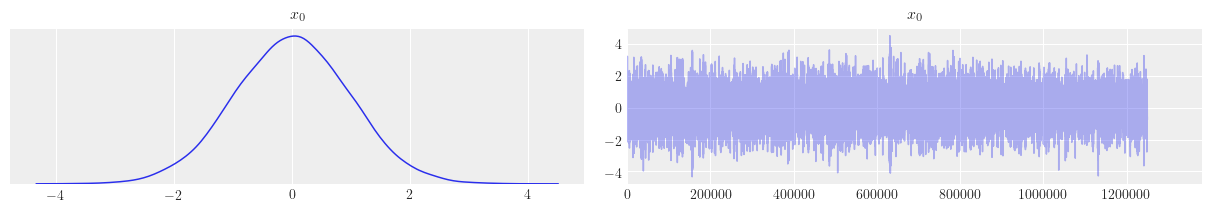

In [43]:
masked_diag.trace_plot('$x_0$')


/data/hylia/thornton/venvs/mbps_venv/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9384bac0d0>,
      dtype=object)

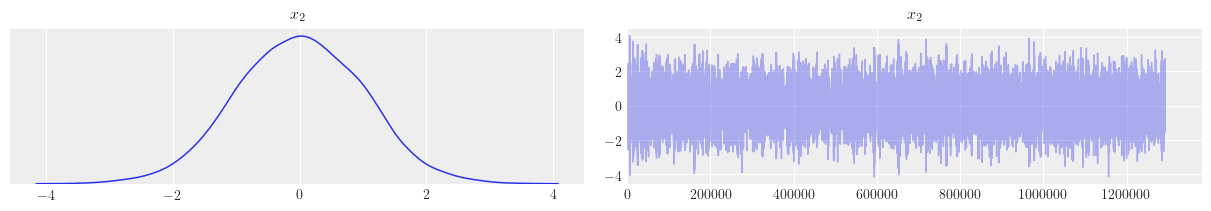

In [44]:
masked_diag.trace_plot('$x_2$')



In [46]:
x2 = masked_diag.get_chain("$x_2$")[0]

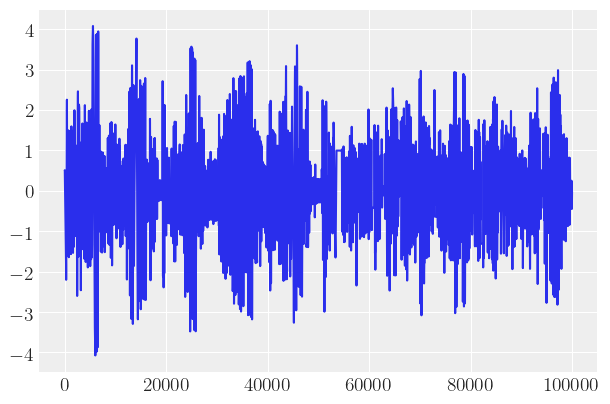

In [53]:
plt.plot(x2[:10**5])

/data/hylia/thornton/venvs/mbps_venv/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f938b55a750>,
      dtype=object)

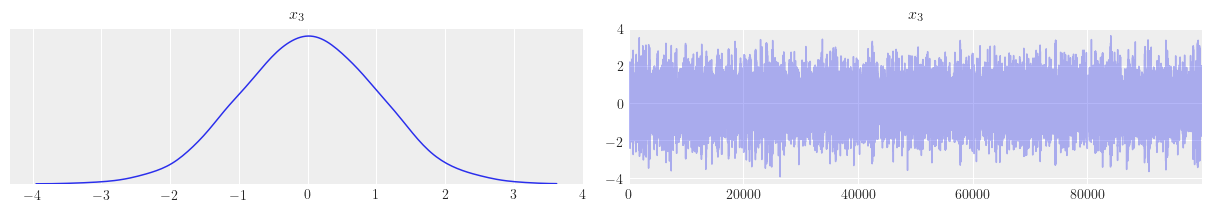

In [17]:
masked_diag.trace_plot('$x_3$')